# Tutorial

From recipe to gridded netcdf product, a how-to!


In [72]:
# Import the functions we are going to use, FYI one day this should be
# a simple import stitches call

import stitches.pangeo_fx as pangeo
import stitches.netcdf_fx as nc
import pandas as pd
import stitches.gridstitch_fx as stitch
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns


## Load recipe

In [2]:
# Load a c, this is a csv file that is generated in the R portion of the
# the project. Note that the recipe must contain information about the
# target and archive years, stitching_id. In columns titled
# with var_file there should pangeo zfile informtion. This can be for an
# arbitrary number variables, so logn as it matches that column
# naming pattern.

recipe = pd.read_csv('/Users/dorh012/projects/2021/stitches/notebooks/stitches_dev/MPI_gridded_recipes_for_python.csv')
recipe.head(3)


,stitching_id,target_start_yr,target_end_yr,archive_start_yr,archive_end_yr,tas_file,activity_id,institution_id,source_id,experiment_id,member_id,pr_file,psl_file
0,ssp245~r7i1p1f1~1,1850,1858,1904,1912,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r10i1p1f1,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...
1,ssp245~r7i1p1f1~1,1859,1867,1850,1858,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r4i1p1f1,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...
2,ssp245~r7i1p1f1~1,1868,1876,1886,1894,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r10i1p1f1,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...


My guess is that the next steps will probably be wrapped into an easy to use
function but for now let's walk through the steps individually.


## Download data

In [3]:
# Save a copy of the unique file list to minimize the number of files we have to
# download from pangeo. Because we are working with an arbitrary number of variables
# use a helper function.
file_list = pangeo.find_zfiles(recipe)

In [9]:
# Now pull the netcdf files directly from pangeo! Here we are
# pulling all of the netcdf files we will need in the stitcing
# process at once to limit the number of times we have to do this.
# the length of time this call takes to run depends on the number of
# files we need to import.
data_list = pangeo.get_data_from_pangeo(file_list)


## Stitch data into product

In [10]:
# Select a single one of the stitching ids to stitch together.
id = recipe['stitching_id'].unique()[0]
x = recipe[recipe['stitching_id'] == id].copy()

# Parse out the variable name so that we can use it
# to label the final output.
file_column_names = x.filter(regex='file').columns.tolist()
vars = nc.get_var_names(file_column_names)

In [11]:
# Create the xarray of the stitched data, we will probably
# want to optimize this.
out = stitch.stitch_gridded(rp=x,
                            dl=data_list,
                            fl=file_list)

In [2]:
# Make a copy of the file name and save.
fname = "stitched_MPI_" + id + '_'+ '_'.join(vars) +".nc"
out.to_netcdf(fname)

TypeError: can only concatenate str (not "builtin_function_or_method") to str

## Let's take a look at what we made!

In [51]:
out.attrs

{'target data': 'Not available until full pipeline in place',
 'stitching_id': "['ssp245~r7i1p1f1~1']",
 'recipe': 'need to figure out how to add this '}

In [16]:
out.tas.attrs

{'cell_measures': 'area: areacella',
 'cell_methods': 'area: time: mean',
 'comment': 'near-surface (usually, 2 meter) air temperature',
 'long_name': 'Near-Surface Air Temperature',
 'standard_name': 'air_temperature',
 'units': 'K'}

In [18]:
out.psl.attrs

{'_ChunkSizes': [1, 96, 192],
 'cell_measures': 'area: areacella',
 'cell_methods': 'area: time: mean',
 'comment': 'Sea Level Pressure',
 'history': '2019-09-12T18:45:41Z altered by CMOR: replaced missing value flag (-9e+33) and corresponding data with standard missing value (1e+20). 2019-09-12T18:45:41Z altered by CMOR: Inverted axis: lat.',
 'long_name': 'Sea Level Pressure',
 'standard_name': 'air_pressure_at_mean_sea_level',
 'units': 'Pa'}

In [19]:
out.pr.attrs


{'cell_measures': 'area: areacella',
 'cell_methods': 'area: time: mean',
 'comment': 'includes both liquid and solid phases',
 'long_name': 'Precipitation',
 'original_name': 'pr',
 'standard_name': 'precipitation_flux',
 'units': 'kg m-2 s-1'}

### maps!

In [ ]:
# tas plot!
out.tas.sel(time='2050-01').squeeze().plot()

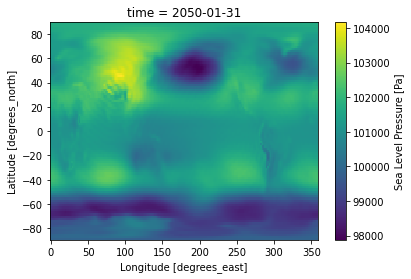

In [53]:
# tas plot!
out.psl.sel(time='2050-01').squeeze().plot()

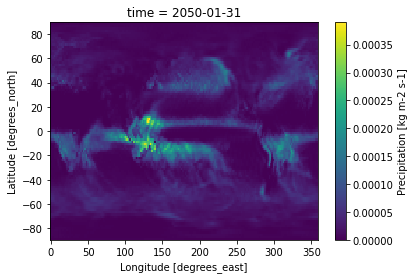

In [54]:
# tas plot!
out.pr.sel(time='2050-01').squeeze().plot()


### global means?

In [74]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def global_mean(ds):
    """Return global mean of a whole dataset."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)


# calculate weighted means
rslt = global_mean(out)

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

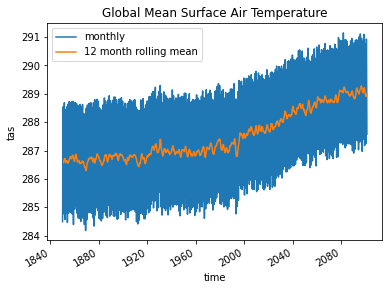

In [75]:
rslt.tas.plot(label='monthly')
rslt.tas.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')



Text(0.5, 1.0, 'Sea Level Pressure')

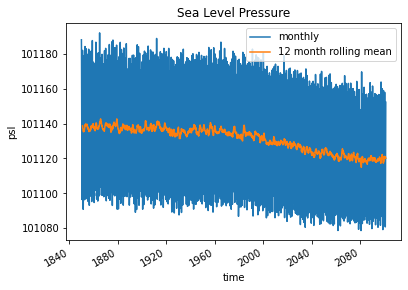

In [79]:
rslt.psl.plot(label='monthly')
rslt.psl.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title(out.psl.attrs['long_name'])

Text(0.5, 1.0, 'Precipitation')

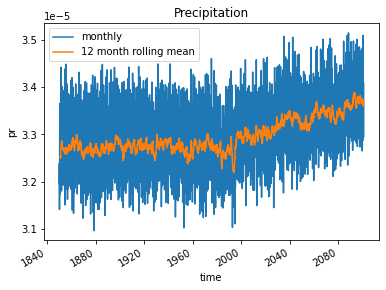

In [80]:
rslt.pr.plot(label='monthly')
rslt.pr.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title(out.pr.attrs['long_name'])



## How to loop over multiple recipes!

Note my guess is that one day this will be wrapped into a function.


In [ ]:
# uncomment code to run 
# Loop through the other recipes
#    for id in recipe['stitching_id'].unique():
#        # subset for a single recipie
#        x = recipe[recipe['stitching_id'] == id].copy()
#
#        # Parse out the variable name so that we can use it
#        # to label the final output.
#        file_column_names = x.filter(regex='file').columns.tolist()
#        vars = get_var_names(file_column_names)
#
#        # Create the xarray of the stitched data, may want to figure if
#        # there is some way to optmize this cause it is a tad slow...
#        out = stitch_gridded(rp=x, dl=data_list, fl=file_list)
#
#        # Make a copy of the file name and save.
#        fname = "stitched_MPI_" + id + '_'+ '_'.join(vars) +".nc"
#        out.to_netcdf(fname)


